### RF forecasting on 2017

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RandomForestModel
from darts.metrics import mape, mae, rmse
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler

import optuna
from optuna.exceptions import TrialPruned

c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [8]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2012-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly = df["Close"].resample("W-FRI").last().to_frame()

series = TimeSeries.from_series(weekly["Close"], fill_missing_dates=True, freq="W")
series = fill_missing_values(series)

C:\Users\USER\AppData\Local\Temp\ipykernel_21020\657078629.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [9]:
def get_splits(series, start_year=2012, end_year=2016):
    splits = []
    for year in range(start_year, end_year):
        train_end = pd.Timestamp(f"{year}-12-31")
        val_start = pd.Timestamp(f"{year+1}-01-01")
        val_end   = pd.Timestamp(f"{year+1}-12-31")
        train_slice = series.slice(series.start_time(), train_end)
        val_slice   = series.slice(val_start, val_end)
        splits.append((train_slice, val_slice))
    return splits

splits = get_splits(series, start_year=2012, end_year=2016)

### RF model

In [10]:
def objective(trial):
    lags        = trial.suggest_int("lags", 4, 52)
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
    max_depth   = trial.suggest_int("max_depth", 5, 30)
    
    fold_errors = []
    for fold_idx, (train_i, val_i) in enumerate(splits):
        # scale each fold (optional for RF, but keeps values in similar range)
        scaler_i = Scaler()
        t_i = scaler_i.fit_transform(train_i)
        v_i = scaler_i.transform(val_i)
        
        # instantiate RF
        model = RandomForestModel(
            lags=lags,
            output_chunk_length=1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
        )
        model.fit(t_i)
        
        # one‐step recursive forecast over val horizon
        pred_s = model.predict(len(v_i), series=t_i)
        pred = scaler_i.inverse_transform(pred_s)
        
        err = mape(val_i, pred)
        fold_errors.append(err)
        
        trial.report(err, step=fold_idx)
        if trial.should_prune():
            raise TrialPruned()
    
    return float(np.mean(fold_errors))


In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print("Best hyperparameters:", study.best_params)

[I 2025-08-05 13:43:32,728] A new study created in memory with name: no-name-e2864f5f-dc7a-4f29-9636-700aee7b8556
[I 2025-08-05 13:43:36,004] Trial 0 finished with value: 6.228113924916637 and parameters: {'lags': 34, 'n_estimators': 350, 'max_depth': 19}. Best is trial 0 with value: 6.228113924916637.
[I 2025-08-05 13:43:39,070] Trial 1 finished with value: 6.237125145243891 and parameters: {'lags': 33, 'n_estimators': 300, 'max_depth': 29}. Best is trial 0 with value: 6.228113924916637.
[I 2025-08-05 13:43:42,315] Trial 2 finished with value: 6.493539870246922 and parameters: {'lags': 43, 'n_estimators': 350, 'max_depth': 10}. Best is trial 0 with value: 6.228113924916637.
[I 2025-08-05 13:43:44,778] Trial 3 finished with value: 6.894763244263106 and parameters: {'lags': 13, 'n_estimators': 350, 'max_depth': 9}. Best is trial 0 with value: 6.228113924916637.
[I 2025-08-05 13:43:48,497] Trial 4 finished with value: 6.241090260825571 and parameters: {'lags': 25, 'n_estimators': 450, 'm

Best hyperparameters: {'lags': 34, 'n_estimators': 350, 'max_depth': 19}


In [13]:
# split train/test again
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))
scaler = Scaler()
train_s = scaler.fit_transform(train_ts)

In [14]:
best = study.best_params
h = len(test_ts)
final_model = RandomForestModel(
    lags=best["lags"],
    output_chunk_length=h,
    n_estimators=best["n_estimators"],
    max_depth=best["max_depth"],
    random_state=42,
)

best

{'lags': 34, 'n_estimators': 350, 'max_depth': 19}

In [15]:
final_model.fit(train_s)
forecast_s = final_model.predict(len(test_ts), series=train_s)
forecast = scaler.inverse_transform(forecast_s)

In [16]:
# shifting up forcast result
# extract the last training value and the first forecast value
last_train_value     = train_ts.values()[-1, 0]
first_forecast_value = forecast.values()[0, 0]

# compute the additive offset
offset = last_train_value - first_forecast_value

# shift the entire forecast up (or down) by that offset
rf_forecast_shifted = forecast + offset

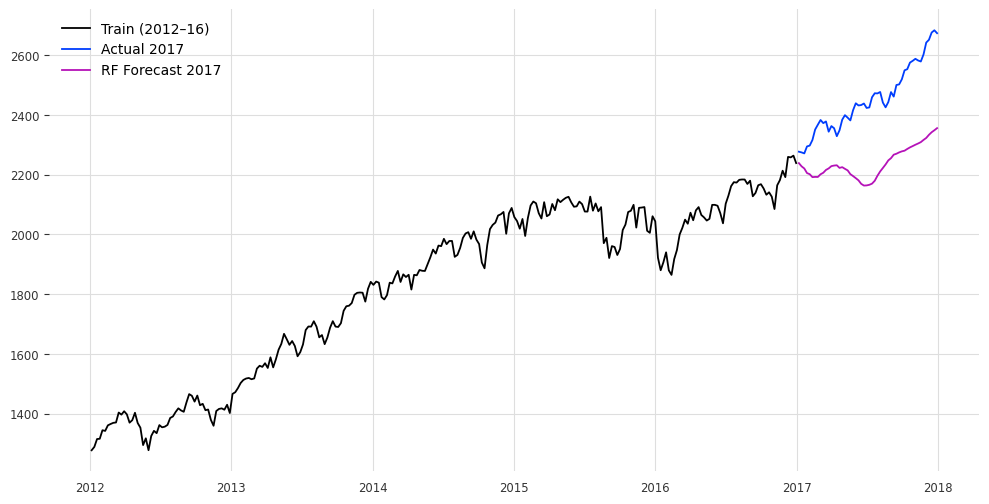

Test MAPE: 8.56%
Test MAE:  212.65
Test RMSE: 226.39


In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train_ts.time_index, train_ts.values(), label="Train (2012–16)")
plt.plot(test_ts.time_index, test_ts.values(), label="Actual 2017")
plt.plot(rf_forecast_shifted.time_index, rf_forecast_shifted.values(), label="RF Forecast 2017")
plt.legend()
plt.show()

print(f"Test MAPE: {mape(test_ts, rf_forecast_shifted):.2f}%")
print(f"Test MAE:  {mae(test_ts, rf_forecast_shifted):.2f}")
print(f"Test RMSE: {rmse(test_ts, rf_forecast_shifted):.2f}")

In [18]:
import os
import pandas as pd

def save_preds(ts_actual, ts_pred, model_name, type, path="results"):
    # turn into pandas.Series and pick only the timestamps present in both
    actual = ts_actual.to_series()
    pred   = ts_pred.to_series()
    common = actual.index.intersection(pred.index)

    # build a simple DataFrame
    df = pd.DataFrame({
        "actual":     actual.loc[common],
        "prediction": pred.loc[common],
        "model":      model_name
    })
    df.index.name = "timestamp"

    # ensure the output folder exists and save
    os.makedirs(path, exist_ok=True)
    out_fn = os.path.join(path, f"{model_name}_{type}.csv")
    df.to_csv(out_fn, index=True)

    return df

In [19]:
df_2017 = save_preds(test_ts, rf_forecast_shifted, model_name="RF", type="test_2017", path="results")

### Forecast on 2023

In [20]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2014-01-01", end="2024-01-01")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly = df["Close"].resample("W-FRI").last().to_frame()

series = TimeSeries.from_series(weekly["Close"], fill_missing_dates=True, freq="W")
series = fill_missing_values(series)

C:\Users\USER\AppData\Local\Temp\ipykernel_21020\3059841700.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [21]:
splits = get_splits(series, start_year=2014, end_year=2022)

In [23]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print("Best hyperparameters:", study.best_params)

[I 2025-08-05 13:46:41,508] A new study created in memory with name: no-name-83aaafcc-095b-4b85-9347-4aaa103be92d
[I 2025-08-05 13:46:49,147] Trial 0 finished with value: 7.990464240664573 and parameters: {'lags': 22, 'n_estimators': 350, 'max_depth': 12}. Best is trial 0 with value: 7.990464240664573.
[I 2025-08-05 13:46:54,969] Trial 1 finished with value: 7.821410646600567 and parameters: {'lags': 11, 'n_estimators': 350, 'max_depth': 22}. Best is trial 1 with value: 7.821410646600567.
[I 2025-08-05 13:47:07,673] Trial 2 finished with value: 8.295362139184544 and parameters: {'lags': 36, 'n_estimators': 500, 'max_depth': 8}. Best is trial 1 with value: 7.821410646600567.
[I 2025-08-05 13:47:18,964] Trial 3 finished with value: 8.817362096686209 and parameters: {'lags': 49, 'n_estimators': 350, 'max_depth': 28}. Best is trial 1 with value: 7.821410646600567.
[I 2025-08-05 13:47:20,689] Trial 4 finished with value: 7.781569063519702 and parameters: {'lags': 11, 'n_estimators': 100, 'm

Best hyperparameters: {'lags': 8, 'n_estimators': 250, 'max_depth': 22}


In [24]:
# split train/test again
train_ts, test_ts = series.split_before(pd.Timestamp("2023-01-01"))
scaler = Scaler()
train_s = scaler.fit_transform(train_ts)

In [25]:
best = study.best_params
h = len(test_ts)
final_model = RandomForestModel(
    lags=best["lags"],
    output_chunk_length=h,
    n_estimators=best["n_estimators"],
    max_depth=best["max_depth"],
    random_state=42,
)

best

{'lags': 8, 'n_estimators': 250, 'max_depth': 22}

In [26]:
final_model.fit(train_s)
forecast_s = final_model.predict(len(test_ts), series=train_s)
forecast = scaler.inverse_transform(forecast_s)

In [27]:
# shifting up forcast result
# extract the last training value and the first forecast value
last_train_value     = train_ts.values()[-1, 0]
first_forecast_value = forecast.values()[0, 0]

# compute the additive offset
offset = last_train_value - first_forecast_value

# shift the entire forecast up (or down) by that offset
rf_forecast_shifted_2 = forecast + offset

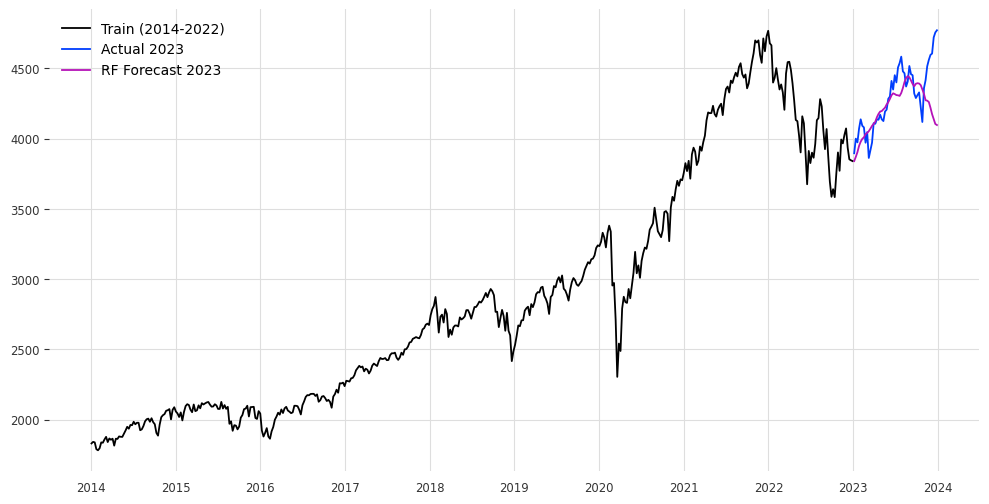

Test MAPE: 3.13%
Test MAE:  138.79
Test RMSE: 206.76


In [28]:
plt.figure(figsize=(12, 6))
plt.plot(train_ts.time_index, train_ts.values(), label="Train (2014-2022)")
plt.plot(test_ts.time_index, test_ts.values(), label="Actual 2023")
plt.plot(rf_forecast_shifted_2.time_index, rf_forecast_shifted_2.values(), label="RF Forecast 2023")
plt.legend()
plt.show()

print(f"Test MAPE: {mape(test_ts, rf_forecast_shifted_2):.2f}%")
print(f"Test MAE:  {mae(test_ts, rf_forecast_shifted_2):.2f}")
print(f"Test RMSE: {rmse(test_ts, rf_forecast_shifted_2):.2f}")

In [29]:
df_2023 = save_preds(test_ts, rf_forecast_shifted_2, model_name="RF", type="test_2023", path="results")

### Backtest

In [38]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2014-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly = df["Close"].resample("W-FRI").last().to_frame()

series = TimeSeries.from_series(weekly["Close"], fill_missing_dates=True, freq="W")
series = fill_missing_values(series)

C:\Users\USER\AppData\Local\Temp\ipykernel_21020\4013117462.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [39]:
scaler = Scaler()
series_s = scaler.fit_transform(series)

In [40]:
# Define backtest period
backtest_start = pd.Timestamp("2023-01-01")
backtest_end   = pd.Timestamp("2024-12-31")
h = len(series[backtest_start:backtest_end]) # length of backtest period

In [44]:
# Run the historical forecasts
RF_backtest_s = final_model.historical_forecasts(
    series          = series_s,
    start           = backtest_start,
    forecast_horizon= 1,       # one week ahead
    stride          = 1,       # move by 1 period each fold
    retrain         = False,    # re-fit at each fold
    last_points_only= True,    # keep only the 1-step point per fold
    verbose         = False
)

In [45]:
# Inverse transform
RF_backtest = scaler.inverse_transform(RF_backtest_s)

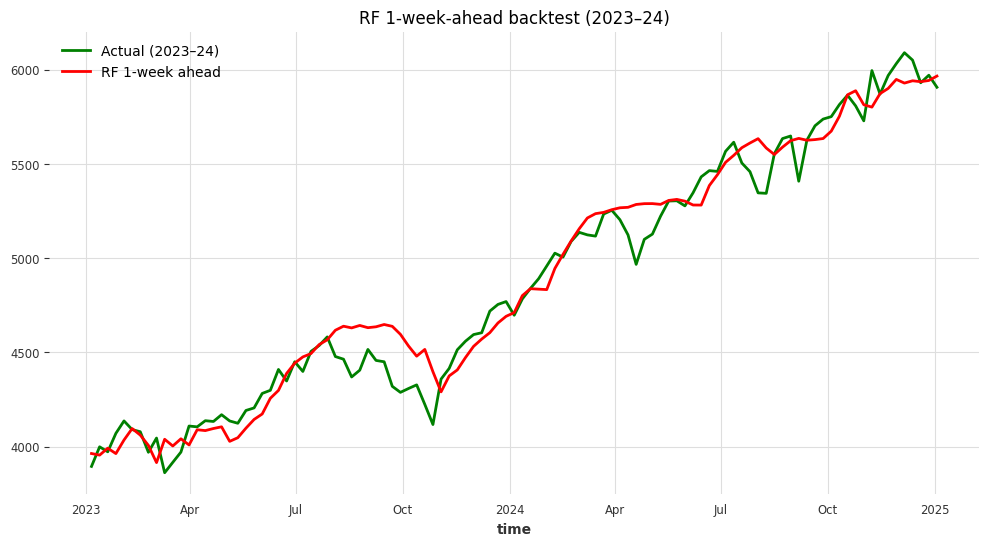

MAPE: 1.96%
MAE:  92.31
RMSE: 122.09


In [46]:
actuals_bt = series[backtest_start:backtest_end]

plt.figure(figsize=(12,6))
actuals_bt.plot(label="Actual (2023–24)", color="green")
RF_backtest.plot(label="RF 1-week ahead", color="red")
plt.legend()
plt.title("RF 1-week-ahead backtest (2023–24)")
plt.show()

print(f"MAPE: {mape(actuals_bt, RF_backtest):.2f}%")
print(f"MAE:  {mae (actuals_bt, RF_backtest):.2f}")
print(f"RMSE: {rmse(actuals_bt, RF_backtest):.2f}")

In [47]:
from sklearn.metrics import precision_score

# convert both to pandas Series for easy shifting/alignment
pred = RF_backtest.to_series() # one-week-ahead forecasts
actual = actuals_bt.to_series() # the real weekly closes

# get last week’s actual price at each forecast date
prev_price = actual.shift(1)

# drop the very first point where prev_price is NaN
mask = prev_price.notna()
pred = pred[mask]
actual = actual[mask]
prev_price = prev_price[mask]

# compute predicted & actual directions: +1 for up, -1 for down
pred_dir   = np.where(pred   > prev_price,  1, -1)
actual_dir = np.where(actual > prev_price,  1, -1)

# compute directional accuracy
dir_acc = (pred_dir == actual_dir).mean() * 100
print(f"Directional accuracy: {dir_acc:.2f}%")

# compute precision for the "up" class
y_pred = (pred_dir == 1)
y_true = (actual_dir == 1)
precision = precision_score(y_true, y_pred) * 100
print(f"Precision (stock actually increase): {precision:.2f}%")

Directional accuracy: 54.81%
Precision (stock actually increase): 64.91%


In [49]:
df_backtest = save_preds(actuals_bt, RF_backtest, model_name="RF", type="backtest", path="results")